In [1]:
# Create metagene average plot combining Ribo- and RNA-seq profiles. 
# This draft script may need to be customized and contain some hard coded fields that
# are specific to the Rp-Bp nomenclature.

# The profiles must be available, and follow the "Rp-Bp format".
# The profiles are extracted for all annotated TISs and TTSs using 5' end of the reads.
# Note: the "library strandedness" is currently hard coded. 

# 12.05.2020

In [65]:

import re
import yaml
import pandas as pd
import numpy as np
import logging

from argparse import Namespace

import pbio.misc.logging_utils as logging_utils
import pbio.misc.mpl_utils as mpl_utils

import pbio.ribo.ribo_utils as ribo_utils

from pproc.defaults import metagene_options

args = Namespace()
logger = logging_utils.get_ipython_logger()


In [66]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import matplotlib.ticker as mtick
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set(style='white', color_codes=True, palette='muted')

params = {
   'axes.labelsize': 26,
   'font.size': 26,
   'legend.fontsize': 24,
   'xtick.labelsize': 24,
   'ytick.labelsize': 24,
    "lines.linewidth": 2.5,
   'text.usetex': True,
   'figure.figsize': [12, 8],
    'font.family': 'sans-serif',
    'font.sans-serif': 'DejaVu Sans',
    'mathtext.fontset': 'dejavusans'
   }
plt.rcParams.update(params)
font = FontProperties().copy()

args.fontsize = params['legend.fontsize']
args.legend_fontsize = params['legend.fontsize']
args.labelsize =params['axes.labelsize']


mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
# I/O

# path to output figure
args.out  = 'metagene_plot.svg'

# path to riboseq metagene profiles and periodic offset files, we could get these from the config...
args.ribo_profiles_loc = 'path/to/metagene-profiles'
args.ribo_periodic_offsets_loc = 'path/to/metagene-profiles'

# path to rnaseq profiles
args.rna_profiles_loc = 'path/to/rna-metagene-profiles'

# the riboseq config file
# to pass to ribo_utils.get_periodic_lengths_and_offsets
args.config = 'path/to/config.yaml'
config = yaml.load(open(args.config), Loader=yaml.FullLoader)
is_unique = not ('keep_riboseq_multimappers' in config)

In [68]:
# make sure we have a trailing /
args.ribo_profiles_loc += '/'
args.ribo_periodic_offsets_loc += '/'
args.rna_profiles_loc += '/'

# basename and extensions, if via Rp-Bp, these names do not need to be modified
args.ribo_profiles_ext = '-unique.metagene-profile.csv.gz'
args.ribo_periodic_offsets_ext = '-unique.periodic-offsets.csv.gz'
args.rna_profiles_ext = '.metagene-profile.csv.gz'


In [69]:
ribo_profiles = !ls $args.ribo_profiles_loc*$args.ribo_profiles_ext 
periodic_offsets = !ls $args.ribo_periodic_offsets_loc*$args.ribo_periodic_offsets_ext

rna_profiles = !ls $args.rna_profiles_loc*$args.rna_profiles_ext 

In [73]:
# parameters to construc the profiles ** these may need to be adjusted!
args.start_upstream_window = -50
args.start_downstream_window = 200
args.start_window_size = args.start_downstream_window - args.start_upstream_window + 1
args.end_upstream_window = -200
args.end_downstream_window = 50
args.end_window_size = args.end_downstream_window - args.end_upstream_window + 1
args.step = 50

args.min_counts = 100 # over window, mainly for rna

In [74]:
def get_window_counts(metagene_profile, offset):
    
    # profile around start codon
    start_upstream = args.start_upstream_window - offset
    start_downstream = args.start_downstream_window - offset
    
    mask_starts = metagene_profile['type'] == 'start'
    m_start_upstream = metagene_profile['position'] >= start_upstream
    m_start_downstream = metagene_profile['position'] <= start_downstream
    
    mask_starts = m_start_upstream & m_start_downstream & mask_starts
    start_counts = metagene_profile.loc[mask_starts, 'count'].values
    #start_positions = metagene_profile.loc[mask_starts, 'position'].values
    
    # profile around stop codon
    end_upstream = args.end_upstream_window - offset
    end_downstream = args.end_downstream_window - offset
    
    mask_ends = metagene_profile['type'] == 'end'
    m_end_upstream = metagene_profile['position'] >= end_upstream
    m_end_downstream = metagene_profile['position'] <= end_downstream

    mask_ends = m_end_upstream & m_end_downstream & mask_ends
    end_counts = metagene_profile.loc[mask_ends, 'count'].values
    #end_positions = metagene_profile.loc[mask_ends, 'position'].values
    
    return start_counts, end_counts
    

In [75]:
# first ribo

all_ribo_metagene_profile_start_df = pd.DataFrame(columns=range(args.start_window_size))
all_ribo_metagene_profile_end_df = pd.DataFrame(columns=range(args.end_window_size))

for profile in ribo_profiles:
    
    sample_name = re.search('{}(.*){}'.format(args.ribo_profiles_loc, args.ribo_profiles_ext), profile).group(1)
    profile_counts = pd.read_csv(profile)
    # periodic_offset_file = 
    # periodic_offsets = pd.read_csv(periodic_offset_file)
    
    lengths, offsets = ribo_utils.get_periodic_lengths_and_offsets(
        config,
        sample_name,
        is_unique=is_unique,
        default_params=metagene_options
    )
    
    window_count_start, window_count_end = 0, 0
    metagene_profile_start = np.zeros(args.start_window_size)
    metagene_profile_end = np.zeros(args.end_window_size)
    for length, offset in zip(lengths, offsets):
        
        m_length = profile_counts['length'] == int(length)
        metagene_profile = profile_counts[m_length]

        starts, ends =  get_window_counts(metagene_profile, int(offset))
        metagene_profile_start += starts
        window_count_start += np.sum(starts)
        metagene_profile_end += ends
        window_count_end += np.sum(ends)

    # collect all profiles for this sample
    metagene_profile_start /= window_count_start
    metagene_profile_end /= window_count_end
    all_ribo_metagene_profile_start_df.loc[sample_name] = metagene_profile_start
    all_ribo_metagene_profile_end_df.loc[sample_name] = metagene_profile_end


In [76]:
# then rna

all_rna_metagene_profile_start_df = pd.DataFrame(columns=range(args.start_window_size))
all_rna_metagene_profile_end_df = pd.DataFrame(columns=range(args.end_window_size))

for profile in rna_profiles:
    sample_name = re.search('{}(.*){}'.format(args.rna_profiles_loc, args.rna_profiles_ext), profile).group(1)
    # get metagene profile, these are for the trimmed rna data, but include different lengths up to max 
    # periodic fragment length of corresponding ribo sample, we use them all
    profile_counts = pd.read_csv(profile)
    lengths = !zcat $profile | sed 1d | cut -d, -f4 | sort | uniq

    window_count_start, window_count_end = 0, 0
    metagene_profile_start = np.zeros(args.start_window_size)
    metagene_profile_end = np.zeros(args.end_window_size)
    
    for length in lengths:
        
        m_length = profile_counts['length'] == int(length)
        metagene_profile = profile_counts[m_length]
        
        if sum(metagene_profile['count']) < args.min_counts:
            continue

        starts, ends =  get_window_counts(metagene_profile, 0) # no offset!
        metagene_profile_start += starts
        window_count_start += np.sum(starts)
        metagene_profile_end += ends
        window_count_end += np.sum(ends)

    # collect all profiles for this sample
    metagene_profile_start /= window_count_start
    metagene_profile_end /= window_count_end
    all_rna_metagene_profile_start_df.loc[sample_name] = metagene_profile_start
    all_rna_metagene_profile_end_df.loc[sample_name] = metagene_profile_end
    

In [77]:
# now get the metagene average
# we take the median of all normalised count vectors at each nt position

# currently we did not exclude count vectors from windows that don't meet a minimum threshold
# for ribo, this is not a problem, since we are only using periodic fragments
# for rna see above

ribo_start = all_ribo_metagene_profile_start_df.median(axis=0)
ribo_end = all_ribo_metagene_profile_end_df.median(axis=0)

rna_start = all_rna_metagene_profile_start_df.median(axis=0)
rna_end = all_rna_metagene_profile_end_df.median(axis=0)


In [78]:
# prepare figure axes

args.title = None #"Periodicity analysis"
args.xlabel_common = "Position relative to CDS (nt)"
args.ylabel = "Normalised read density (arb. unit)"

ymax_ribo = max(max(ribo_start), max(ribo_end))
ymax_rna = max(max(rna_start), max(rna_end))
ymax = 1.1*max(ymax_ribo, ymax_rna) # likely to be ribo anyway...

# labels around the translation start (start codon)
# the +1 is to ensure we actually see the last start_downstream position in the labels
xticklabels_start = range(args.start_upstream_window, args.start_downstream_window+1, args.step)
xticks_start = range(0, args.start_window_size, args.step)

# labels around the stop codon
xticklabels_end = range(args.end_upstream_window, args.end_downstream_window+1, args.step)
xticks_end = range(0, args.start_window_size, args.step)


In [119]:
%%capture
fig, axes = plt.subplots(ncols=2, figsize=(12,6), sharey=True);
colors = sns.color_palette("Set3", 5);

In [120]:
# start site, ribo, then rna
x_pos = np.arange(args.start_window_size)
x_ribo_rects = axes[0].plot(x_pos, ribo_start, color=colors[-1])
x_rna_rects = axes[0].plot(x_pos, rna_start, color=colors[0])

# stop site, ribo, then rna
x_pos = np.arange(args.end_window_size)
x_ribo_rects = axes[1].plot(x_pos, ribo_end, color=colors[-1], label="Ribo-seq")
x_rna_rects = axes[1].plot(x_pos, rna_end, color=colors[0], label="RNA-seq")

# add labels, etc.
axes[0].set_ylabel(args.ylabel, fontsize=args.fontsize)
#axes[0].set_xlabel(args.xlabel_start, fontsize=args.fontsize)
#axes[1].set_xlabel(args.xlabel_end, fontsize=args.fontsize)

if args.title is not None:
    fig.suptitle(args.title, fontsize=args.font_size, y=1.03)

axes[0].set_xticks(xticks_start)
axes[0].set_xticklabels(xticklabels_start)
axes[0].tick_params(labelsize=args.fontsize)

axes[1].set_xticks(xticks_end)
axes[1].set_xticklabels(xticklabels_end)
axes[1].tick_params(labelsize=args.fontsize)

axes[0].set_ylim((0, ymax))

d = .007 # how big to make the diagonal lines in axes coordinates
vertical_adj = 3 # a factor for controlling the vertical slope
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=axes[0].transAxes, color='k', clip_on=False)
axes[0].plot((1-d,1+d), (-vertical_adj*d,+vertical_adj*d), **kwargs)
axes[0].plot((1-d,1+d),(1-vertical_adj*d,1+vertical_adj*d), **kwargs)

kwargs.update(transform=axes[1].transAxes)  # switch to the bottom axes
axes[1].plot((-d,+d), (1-vertical_adj*d,1+vertical_adj*d), **kwargs)
axes[1].plot((-d,+d), (-vertical_adj*d,+vertical_adj*d), **kwargs)

# hide the spines between ax and ax2
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[0].yaxis.tick_left()
axes[0].tick_params(labelright='off')
axes[1].axes.get_yaxis().set_visible(False)
# axes[1].yaxis.tick_right()

# legend to right plot
axes[1].legend(fontsize=args.fontsize)

# common xlabel
fig.text(0.5, -0.005, args.xlabel_common, ha='center', fontsize=args.fontsize);


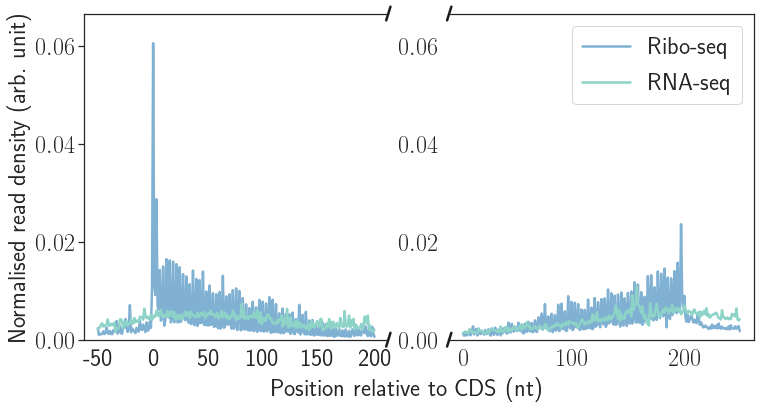

In [121]:
fig # looks like there some issue with the ylabels... 

In [13]:
fig.tight_layout()
fig.savefig(args.out, bbox_inches='tight')